In [1]:
!pip install tensorflow
!pip install numpy matplotlib
!pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Direktori dataset
train_dir = "dataset\\eye_cataracwithlabels\\train"
valid_dir = "dataset\\eye_cataracwithlabels\\valid"
test_dir = "dataset\\eye_cataracwithlabels\\test"

# Define labels
class_labels = ['Immature', 'Mature', 'Normal']

# Data Augmentation untuk training, validasi, dan test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3712 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.


In [4]:
# Menggunakan MobileNetV2 untuk transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

# Menambahkan layer custom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_labels), activation='softmax')(x)

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan arsitektur model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Callbacks untuk early stopping, model checkpoint, dan learning rate scheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Membuat callback untuk menyimpan model terbaik selama training
checkpoint = ModelCheckpoint(
    filepath='best_cataract_model.keras', 
    monitor='val_accuracy',             
    save_best_only=True,                 
    verbose=1                          
)

# Callback untuk menghentikan pelatihan jika validasi loss tidak membaik
early_stopping = EarlyStopping(
    monitor='val_loss',                  
    patience=5,                         
    restore_best_weights=True,           
    verbose=1                            
)

# Callback untuk mengurangi learning rate jika validasi loss stagnan
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',                
    factor=0.5,                         
    patience=3,                         
    verbose=1                           
)

# Melatih model
history = model.fit(
    train_generator,                    
    steps_per_epoch=train_generator.samples // train_generator.batch_size, 
    epochs=50,                          
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size, 
    callbacks=[checkpoint, early_stopping, lr_scheduler] 
)


c:\Users\Ria\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5503 - loss: 1.0455
Epoch 1: val_accuracy improved from -inf to 0.84128, saving model to best_cataract_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.5510 - loss: 1.0437 - val_accuracy: 0.8413 - val_loss: 0.4590 - learning_rate: 0.0010
Epoch 2/50


c:\Users\Ria\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_accuracy improved from 0.84128 to 0.95238, saving model to best_cataract_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9524 - val_loss: 0.2181 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7620 - loss: 0.5841
Epoch 3: val_accuracy did not improve from 0.95238
116/116 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7620 - loss: 0.5839 - val_accuracy: 0.8799 - val_loss: 0.3288 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.95238
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9048 - val_loss: 0.1887 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7939 - loss: 0.5077
Epoch 5: val_accuracy did not improve from 0.95238
116/116 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.7940 - loss: 0.5074 - val_accuracy: 0.8627 - val_loss: 0.3263 - learn

In [6]:
# Menghitung akurasi dan loss pada data validation
train_loss, train_acc = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
print(f'Train Accuracy: {train_acc*100:.2f}%')
print(f'Train Loss: {train_loss:.4f}')

val_loss, val_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Validation Loss: {val_loss:.4f}')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

116/116 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8912 - loss: 0.2829
Train Accuracy: 89.39%
Train Loss: 0.2779
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 835ms/step - accuracy: 0.9125 - loss: 0.2578
Validation Accuracy: 94.41%
Validation Loss: 0.1738
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9205 - loss: 0.2401
Test Accuracy: 94.99%


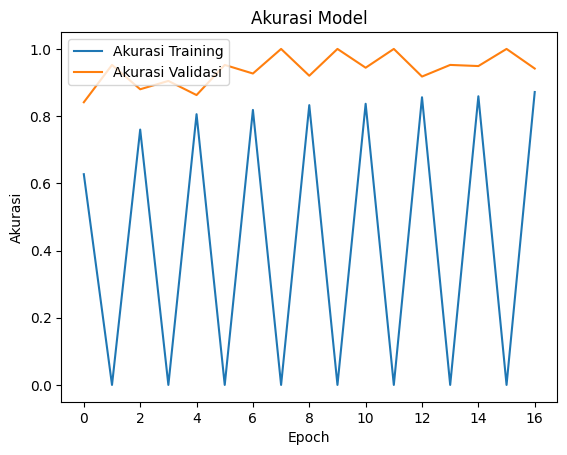

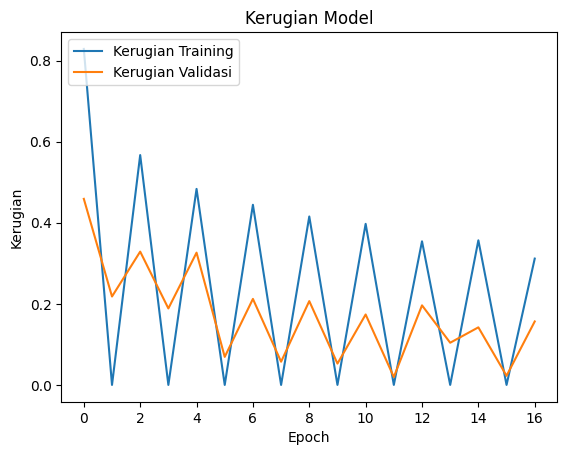

In [7]:
# Visualisasi hasil pelatihan
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='Kerugian Training')
plt.plot(history.history['val_loss'], label='Kerugian Validasi')
plt.title('Kerugian Model')
plt.xlabel('Epoch')
plt.ylabel('Kerugian')
plt.legend(loc='upper left')
plt.show()

Model berhasil dimuat.
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 793ms/step - accuracy: 0.9172 - loss: 0.2673
Test Accuracy: 92.40%
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 818ms/step
Classification Report:
              precision    recall  f1-score   support

    Immature       0.87      0.92      0.89       368
      Mature       0.95      0.86      0.90       421
      Normal       0.95      0.98      0.97       448

    accuracy                           0.92      1237
   macro avg       0.92      0.92      0.92      1237
weighted avg       0.93      0.92      0.92      1237



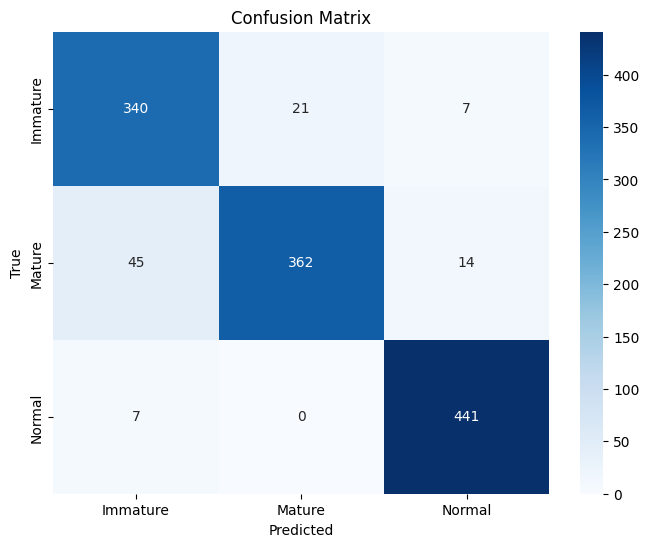

Model berhasil disimpan sebagai 'final_cataract_model.keras'
INFO:tensorflow:Assets written to: C:\Users\Ria\AppData\Local\Temp\tmp6ywp4o0f\assets


INFO:tensorflow:Assets written to: C:\Users\Ria\AppData\Local\Temp\tmp6ywp4o0f\assets


Saved artifact at 'C:\Users\Ria\AppData\Local\Temp\tmp6ywp4o0f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1871158391632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158392976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158392016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158393744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158390480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158393360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158392784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158392208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158391248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158394320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871158

In [8]:
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pastikan file model tersedia sebelum memuatnya
if os.path.exists('best_cataract_model.keras'):
    model.load_weights('best_cataract_model.keras') 
    print("Model berhasil dimuat.")
else:
    print("File 'best_cataract_model.keras' tidak ditemukan. Pastikan model telah disimpan sebelumnya.")
    raise FileNotFoundError("Model file 'best_cataract_model.keras' tidak ditemukan.")

# Evaluasi pada data test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Membuat prediksi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Laporan klasifikasi
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Simpan model dalam format Keras
try:
    model.save('final_cataract_model.keras')
    print("Model berhasil disimpan sebagai 'final_cataract_model.keras'")
except Exception as e:
    print(f"Gagal menyimpan model: {e}")

# Konversi ke TensorFlow Lite
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open('cataract_model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("Model berhasil dikonversi ke TensorFlow Lite.")
except Exception as e:
    print(f"Gagal mengonversi model ke TensorFlow Lite: {e}")